Sample: 100%|███████████████████████████████████████| 1000/1000 [01:31, 10.89it/s, step size=1.98e-02, acc. prob=0.830]


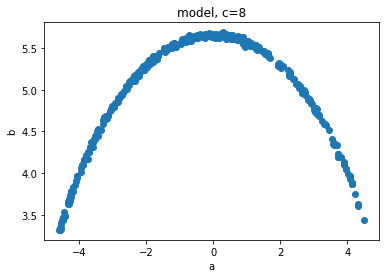

loss @ 0 7.510082811117172
loss @ 200 3.194806307554245
loss @ 400 3.3414379358291626
loss @ 600 2.9036999344825745
loss @ 800 2.546404644846916
loss @ 1000 2.4830171018838882
loss @ 1200 2.543608218431473
loss @ 1400 3.1607170552015305
loss @ 1600 5.678181394934654
loss @ 1800 3.5155403316020966
loss @ 2000 2.6901869028806686
loss @ 2200 2.447136953473091
loss @ 2400 2.756696715950966
loss @ 2600 3.2518062591552734
loss @ 2800 2.7020223438739777
loss @ 3000 2.1848961114883423
loss @ 3200 2.937690854072571
loss @ 3400 4.553872913122177
loss @ 3600 3.2124137431383133
loss @ 3800 3.007596328854561
loss @ 4000 3.210890054702759
loss @ 4200 2.753877967596054
loss @ 4400 3.1348226368427277
loss @ 4600 2.987026810646057
loss @ 4800 2.837288558483124
loss @ 5000 2.9772588312625885
loss @ 5200 2.749754436314106
loss @ 5400 3.9267347902059555
loss @ 5600 3.5182961225509644
loss @ 5800 2.673917382955551
loss @ 6000 3.4136974215507507
loss @ 6200 5.50447453558445
loss @ 6400 3.252108633518219
los

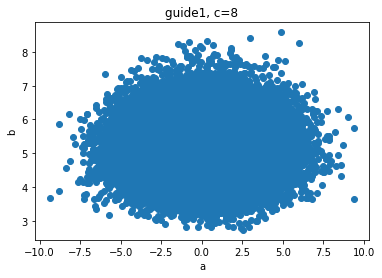

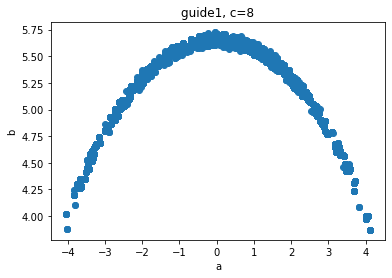

loss @ 0 8.558740884065628
loss @ 200 2.8156425803899765
loss @ 400 3.023853525519371
loss @ 600 2.1401342526078224
loss @ 800 3.1396401152014732
loss @ 1000 2.283238749951124
loss @ 1200 5.36152807623148
loss @ 1400 2.073437012732029
loss @ 1600 2.3238563388586044
loss @ 1800 2.3911690711975098
loss @ 2000 3.953644335269928
loss @ 2200 2.4148243218660355
loss @ 2400 3.3603626489639282
loss @ 2600 2.5420383624732494
loss @ 2800 2.679525174200535
loss @ 3000 2.4435269236564636
loss @ 3200 3.0677572786808014
loss @ 3400 2.6917065009474754
loss @ 3600 2.247474782168865
loss @ 3800 2.404759109020233
loss @ 4000 2.364246755838394
loss @ 4200 3.034629262983799
loss @ 4400 2.645252253860235
loss @ 4600 2.136393815279007
loss @ 4800 2.7721020728349686
loss @ 5000 2.244068428874016
loss @ 5200 3.157040512189269
loss @ 5400 2.31718890927732
loss @ 5600 2.4439000338315964
loss @ 5800 2.404970243573189
loss @ 6000 2.1267881989479065
loss @ 6200 4.500814005732536
loss @ 6400 2.36824694275856
loss @

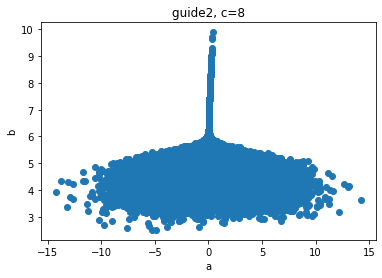

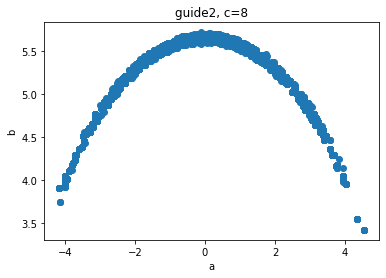

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pyro
import torch
import torch.nn as nn
import torch.nn.functional as F

import pyro
import pyro.distributions as dist
import pyro.infer
import pyro.optim
from pyro.optim import Adam
from pyro.infer import SVI, Trace_ELBO, TraceGraph_ELBO, MCMC, NUTS

def make_plot(x, y, main):
    plt.plot(x, y, "o")
    plt.title(main)
    plt.xlabel("a")
    plt.ylabel("b")
    plt.show()
    
class simpleNN(nn.Module):
    def __init__(self, input_size=1, hidden=32, out_size=1, t="normal", out_non_linear=None):
        super().__init__()
        self.t = t
        self.out_non_linear = out_non_linear
        self.hiddeen_layer = nn.Linear(input_size, hidden)
        if t == "normal" or t == "gamma":
            self.loc_layer = nn.Linear(hidden, out_size)
            self.std_layer = nn.Linear(hidden, out_size)
            self.softplus = nn.Softplus()
        elif t == "bern":
            self.prob_layer = nn.Linear(hidden, out_size)
        elif t == "mlp":
            self.out_layer = nn.Linear(hidden, out_size)
        
    def forward(self, x_list):
        for i in range(len(x_list)):
            if x_list[i].dim() == 0:
                x_list[i] = torch.unsqueeze(x_list[i], dim=0)
        input_x = torch.cat(x_list, 0)
        hid = F.relu(self.hiddeen_layer(input_x))
        # return loc, std
        if self.t == "normal":
            return self.loc_layer(hid), self.softplus(self.std_layer(hid))
        elif self.t == "gamma":
            return self.softplus(self.loc_layer(hid)), self.softplus(self.std_layer(hid))
        elif self.t == "bern":
            return torch.sigmoid(self.prob_layer(hid))
        else:
            if self.out_non_linear == "tanh":
                return torch.tanh(self.out_layer(hid))
            else:
                return self.out_layer(hid)
    
g1_nnb_c = simpleNN(t="gamma")
g1_nna_c = simpleNN()
g2_nnb_c = simpleNN(t="gamma")
g2_nna_c = simpleNN(input_size=2)

guide1_a = []
guide1_b = []
guide2_a = []
guide2_b = []
    
def model(observations={"c" : 0}):
    a = pyro.sample("a", dist.Normal(0, 2))
    b = pyro.sample("b", dist.Gamma(8, 2))
    c = pyro.sample("c", dist.Normal(a*a / 4 + b*b / 4, 0.05), obs=observations["c"])
    return c
    #return {"a" : a, "b" : b, "c" : c}

def guide1(observations={"c" : 0}):
    pyro.module("g1_nnb_c", g1_nnb_c)
    pyro.module("g1_nna_c", g1_nna_c)
    c = observations["c"]
    b_alpha, b_beta = g1_nnb_c([c])
    b = pyro.sample("b", dist.Gamma(b_alpha, b_beta))
    a_mu, a_sig = g1_nna_c([c])
    a = pyro.sample("a", dist.Normal(a_mu, a_sig))
#     guide1_a.append(a.detach().numpy())
#     guide1_b.append(b.detach().numpy())
    return a.detach().numpy(), b.detach().numpy()

def guide2(observations={"c" : 0}):
    pyro.module("g2_nnb_c", g2_nnb_c)
    pyro.module("g2_nna_c", g2_nna_c)
    c = observations["c"]
    b_alpha, b_beta = g2_nnb_c([c])
    b = pyro.sample("b", dist.Gamma(b_alpha, b_beta))
    a_mu, a_sig = g2_nna_c([c, b])
    a = pyro.sample("a", dist.Normal(a_mu, a_sig))
#     guide2_a.append(a.detach().numpy())
#     guide2_b.append(b.detach().numpy())
    return a.detach().numpy(), b.detach().numpy()
    
c = torch.tensor(8.)
mcmc_num_samples = 500
num_samples = 50000
num_inference_samples = 10000

nuts_kernel = NUTS(model)
mcmc = MCMC(nuts_kernel, num_samples=mcmc_num_samples)
mcmc.run({"c": c})
model_samples = mcmc.get_samples()
model_a = model_samples["a"].detach().numpy()
model_b = model_samples["b"].detach().numpy()
make_plot(model_a, model_b, main="model, c="+str(int(c)))

def run_guide_csis(guide):
    pyro.clear_param_store()
    global g1_nnb_c, g1_nna_c, g2_nnb_c, g2_nna_c
    g1_nnb_c = simpleNN(t="gamma")
    g1_nna_c = simpleNN()
    g2_nnb_c = simpleNN(t="gamma")
    g2_nna_c = simpleNN(input_size=2)
    adam_params = {"lr": 0.005, "betas": (0.95, 0.999)}
    optimizer = Adam(adam_params)
    n_steps = 10000
    csis = pyro.infer.CSIS(model, guide, optimizer, num_inference_samples=num_inference_samples)

    for step in range(n_steps):
        loss = csis.step()
        if step % 200 == 0:
            print("loss @ " + str(step), loss)
    posterior = csis.run(observations={"c": c})
    marginal = pyro.infer.EmpiricalMarginal(posterior, ["a", "b"])
    csis_samples_a = []
    csis_samples_b = []
    for _ in range(num_samples):
        sample = marginal()
        a = float(sample[0])
        b = float(sample[1])
        csis_samples_a.append(a)
        csis_samples_b.append(b)
    return csis_samples_a, csis_samples_b

guide1_a_is, guide1_b_is = run_guide_csis(guide1)
for _ in range(num_samples):
    a, b =guide1({"c" : c})
    guide1_a.append(a)
    guide1_b.append(b)
make_plot(guide1_a, guide1_b, main="guide1, c="+str(int(c)))
make_plot(guide1_a_is, guide1_b_is, main="guide1, c="+str(int(c)))

guide2_a_is, guide2_b_is = run_guide_csis(guide2)
for _ in range(num_samples):
    a, b =guide2({"c" : c})
    guide2_a.append(a)
    guide2_b.append(b)
make_plot(guide2_a, guide2_b, main="guide2, c="+str(int(c)))
make_plot(guide2_a_is, guide2_b_is, main="guide2, c="+str(int(c)))